# Sendo a base apresentada no arquivo abaixo:
- https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_customers_dataset.csv
    - Já disponível no banco de dados `vendas_db.db` através do link:
        - https://drive.google.com/file/d/1eONzrbEu5BoijDRj56gjL_2Ik5qxtR6U/view?usp=sharing
<br><br>
- Sua tarefa é ajudar a área de negócios a **montar uma apresentação para a diretoria** para provar a **necessidade de investistimento em uma área de melhoria da experência do cliente ao ter um atraso na entrega**
<br><br>
- Algumas considerações são importantes
    - O **time de logística não considera que o atraso na entrega é um problema relevante** e falou que, em média, as entregas estão sendo feitas 10 dias antes do prazo combinado
    - Não é desejado a previsão de uma entrega atrasada, apenas a **exposição que esse é um problema que pode impactar os clientes**
    - Não queremos uma abordagem de: "nenhuma entrega pode atrasar". Vamos ser mais tranquilos e seguir na linha de: **"uma entrega pode atrasar. Como eu posso melhorar a experiência do cliente caso isso aconteça?"**

# preparando nosso 'ambiente'

In [1]:
# importando o sqlite e o pandas
import pandas as pd
import sqlite3

In [2]:
# criando um conexao
con = sqlite3.connect('vendas_db.db')

In [3]:
#criando o cursor
cur = con.cursor()

In [7]:
# Utilizando a função que já criamos
def executa_consulta (consulta):
    resultado = cur.execute(consulta).fetchall()
    resultado = pd.DataFrame(resultado)
    colunas = [i[0] for i in cur.description]
    if resultado.shape[1] > 0:
        resultado.columns = colunas
    print(resultado.shape)
    display(resultado.head(3))
    return resultado

In [8]:
# Verificando as tabelas existentes no banco de dados
executa_consulta ('SELECT * FROM sqlite_schema WHERE type = "table"')

(9, 5)


,type,name,tbl_name,rootpage,sql
0,table,customers,customers,2,"CREATE TABLE ""customers"" (\n""index"" INTEGER,\n..."
1,table,geolocation,geolocation,2644,"CREATE TABLE ""geolocation"" (\n""index"" INTEGER,..."
2,table,order_items,order_items,22586,"CREATE TABLE ""order_items"" (\n""index"" INTEGER,..."


,type,name,tbl_name,rootpage,sql
0,table,customers,customers,2,"CREATE TABLE ""customers"" (\n""index"" INTEGER,\n..."
1,table,geolocation,geolocation,2644,"CREATE TABLE ""geolocation"" (\n""index"" INTEGER,..."
2,table,order_items,order_items,22586,"CREATE TABLE ""order_items"" (\n""index"" INTEGER,..."
3,table,order_payments,order_payments,27121,"CREATE TABLE ""order_payments"" (\n""index"" INTEG..."
4,table,order_reviews,order_reviews,29140,"CREATE TABLE ""order_reviews"" (\n""index"" INTEGE..."
5,table,products,products,33215,"CREATE TABLE ""products"" (\n""index"" INTEGER,\n ..."
6,table,sellers,sellers,33909,"CREATE TABLE ""sellers"" (\n""index"" INTEGER,\n ..."
7,table,product_category_name_translation,product_category_name_translation,33966,"CREATE TABLE ""product_category_name_translatio..."
8,table,orders,orders,17570,"CREATE TABLE ""orders"" (\n""index"" INTEGER,\n ""..."


# o atraso e um problema real ?

In [68]:
# vizualizando a tabela de pedidos
pedidos = executa_consulta('SELECT order_id, \
                            order_purchase_timestamp, \
                            order_delivered_customer_date, \
                            order_estimated_delivery_date \
                           FROM orders \
                           WHERE order_delivered_customer_date IS NOT NULL')

(96476, 4)


,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04 00:00:00


In [69]:
# verificando as informacoes da tabela
pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96476 entries, 0 to 96475
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       96476 non-null  object
 1   order_purchase_timestamp       96476 non-null  object
 2   order_delivered_customer_date  96476 non-null  object
 3   order_estimated_delivery_date  96476 non-null  object
dtypes: object(4)
memory usage: 2.9+ MB


In [70]:
# ajustando o tipo das colunas de data
lista_colunas = ['order_purchase_timestamp','order_delivered_customer_date','order_estimated_delivery_date']
for i in lista_colunas:
    pedidos[i] = pd.to_datetime(pedidos[i],format='ISO8601')

In [71]:
import datetime as dt

In [72]:
# considerando pedidos apenas pedidos apos 2017
pedidos = pedidos[pedidos.order_purchase_timestamp.dt.year >= 2017]

In [73]:
# calculanddo a diferença entre a data estimada e a data entregue
(pedidos.order_estimated_delivery_date.dt.date - pedidos.order_delivered_customer_date.dt.date)

0         8 days, 0:00:00
1         6 days, 0:00:00
2        18 days, 0:00:00
3        13 days, 0:00:00
4        10 days, 0:00:00
               ...       
96471    11 days, 0:00:00
96472     2 days, 0:00:00
96473     6 days, 0:00:00
96474    21 days, 0:00:00
96475    18 days, 0:00:00
Length: 96204, dtype: object

In [74]:
pedidos['atraso'] = (pedidos['order_estimated_delivery_date'] - pedidos['order_delivered_customer_date']).dt.days

In [75]:
# verificando a media dos atraso
pedidos.atraso.mean()

10.80772109267806

In [76]:
# verificando o periodo (mes/ano) da compra
pedidos['mes'] = pedidos.order_purchase_timestamp.dt.to_period('M')

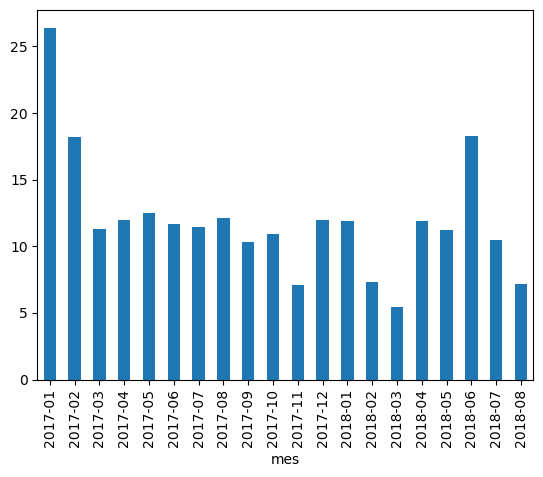

In [78]:
# verificanddo o atraso por mês
pedidos.groupby('mes')['atraso'].mean().plot.bar();

# realmente  a media das entregas e de 10 dias, mas a media e um bom indicador ?

In [82]:
# alem da media vamos analisar o maximo e o minimo
media = pedidos.groupby('mes')['atraso'].mean()
minimo = pedidos.groupby('mes')['atraso'].min()
maximo = pedidos.groupby('mes')['atraso'].max()

In [83]:
import matplotlib.pyplot as plt
import numpy as np

In [86]:
media.values

array([26.408     , 18.1954023 , 11.32717989, 11.97177594, 12.49788434,
       11.64433812, 11.47081612, 12.09754352, 10.34819277, 10.92340331,
        7.12349067, 12.0085253 , 11.9343613 ,  7.28767541,  5.42767385,
       11.89511621, 11.19099126, 18.24409449, 10.44152047,  7.16217918])

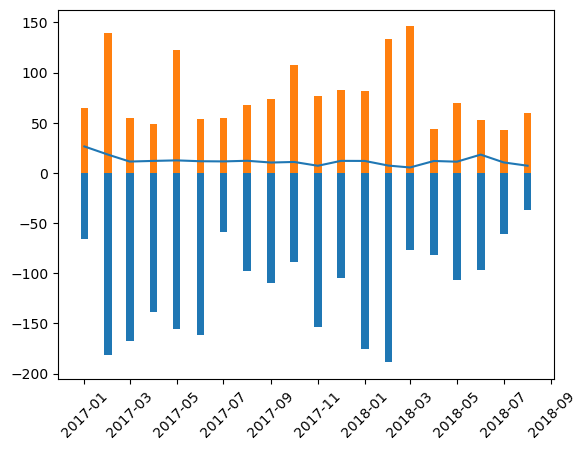

In [93]:
# plotando graficamente
fig, ax = plt.subplots()

ax.plot(media.index.to_timestamp(), media.values)
ax.bar(minimo.index.to_timestamp(), minimo.values,width=10)
ax.bar(maximo.index.to_timestamp(), maximo.values,width=10)

plt.xticks(rotation=45)

plt.show()

# E se analisarmos a quantidades de pedidos com atraso ?

In [95]:
# criando um marcacao para verificar se o pedido arasou ou nao
def pedidos_atrasados(x):
    if x < 0:
        return 1
    else:
        return 0
    

In [97]:
pedidos['flag_atraso'] = pedidos.atraso.apply(pedidos_atrasados)

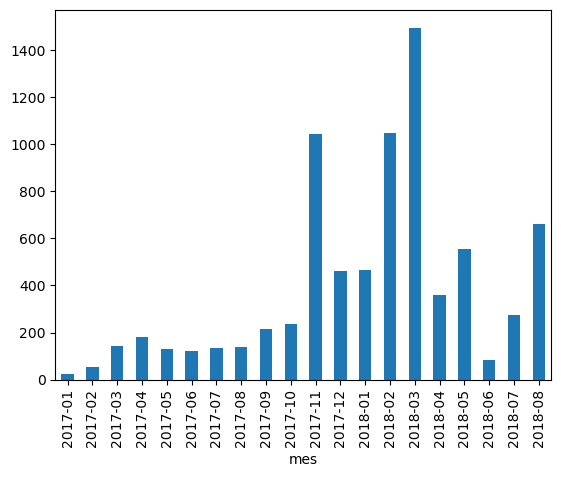

In [99]:
# e contando, mensalmente, quantos pedidos atrasaram
pedidos.groupby('mes')['flag_atraso'].sum().plot.bar();

In [101]:
# analisando a relacao entre o numero de pedidos feitos e atrasados
pedidos_atrasados = pedidos.groupby('mes')['flag_atraso'].sum()
contagem_pedidos = pedidos.groupby('mes')['flag_atraso'].count()

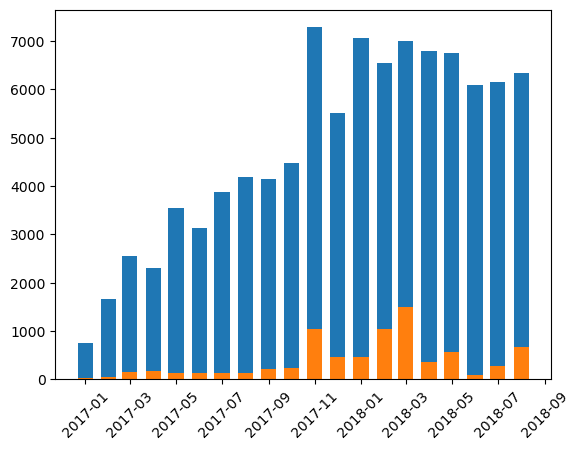

In [104]:
# vizualizando graficamente
fig, ax = plt.subplots()

ax.bar(contagem_pedidos.index.to_timestamp(), contagem_pedidos.values,width=20)
ax.bar(pedidos_atrasados.index.to_timestamp(), pedidos_atrasados.values,width=20)

plt.xticks(rotation=45)

plt.show()

In [106]:
(pedidos_atrasados/contagem_pedidos)*100

mes
2017-01     3.066667
2017-02     3.206292
2017-03     5.577376
2017-04     7.859314
2017-05     3.610719
2017-06     3.859649
2017-07     3.434917
2017-08     3.315049
2017-09     5.204819
2017-10     5.292541
2017-11    14.311196
2017-12     8.380192
2018-01     6.563870
2018-02    16.000610
2018-03    21.362273
2018-04     5.310385
2018-05     8.238258
2018-06     1.361549
2018-07     4.483431
2018-08    10.392064
Freq: M, Name: flag_atraso, dtype: float64

In [107]:
pedidos_atraso = pedidos_atrasados
contagem = contagem_pedidos
percentual = round((pedidos_atrasados/contagem_pedidos)*100,1)

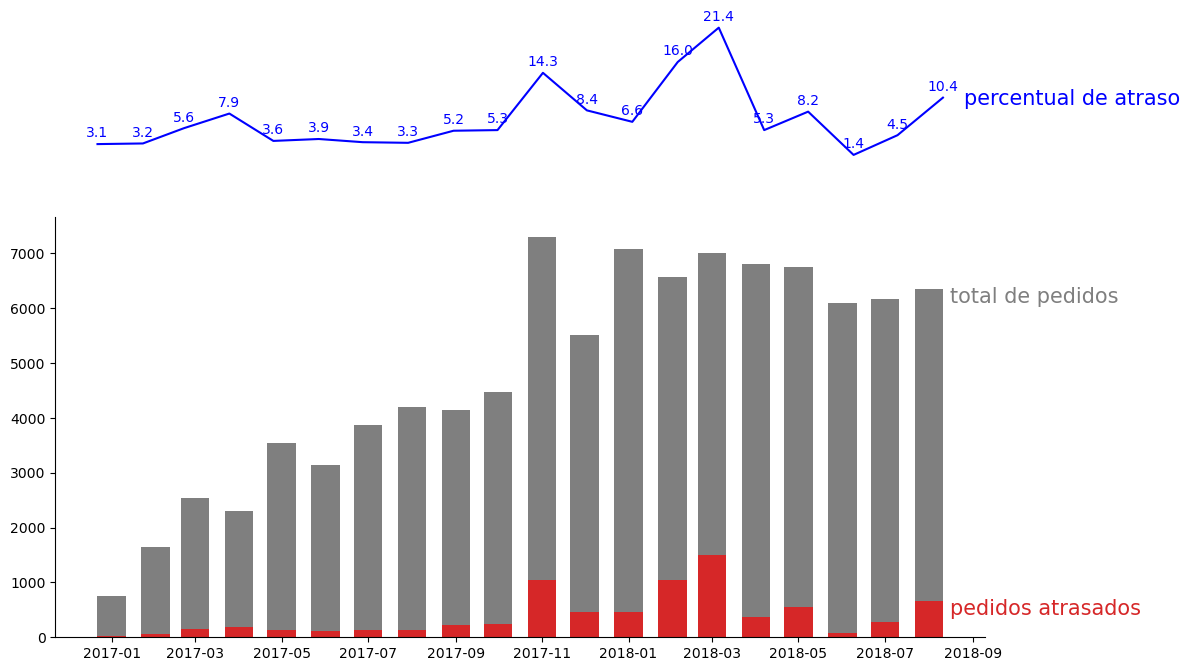

In [148]:
# melhorando a vizualizacao
fig, ax = plt.subplots(nrows=2, figsize=(12,8),gridspec_kw={'height_ratios': [1,3]})

ax[1].bar(contagem_pedidos.index.to_timestamp(), contagem_pedidos.values,width=20,color='tab:gray')
ax[1].bar(pedidos_atrasados.index.to_timestamp(), pedidos_atrasados.values,width=20,color='tab:red')

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[1].annotate('total de pedidos',(contagem_pedidos.index.to_timestamp()[-1],contagem_pedidos.values[-1])
               ,ha="left",xytext=(15,-10),textcoords="offset points",c='tab:gray',fontsize=15)
ax[1].annotate('pedidos atrasados',(pedidos_atrasados.index.to_timestamp()[-1],pedidos_atrasados.values[-1])
               ,ha="left",xytext=(15,-10),textcoords="offset points",c='tab:red',fontsize=15)

ax[0].plot(percentual.index.to_timestamp(), percentual.values, c='b')

for i in range(0,len(percentual)):
    ax[0].annotate(percentual.values[i],(percentual.index.to_timestamp()[i],percentual.values[i])
               ,ha="center",xytext=(0,5),textcoords="offset points",c='b')

ax[0].annotate('percentual de atraso',(percentual.index.to_timestamp()[-1],percentual.values[-1])
               ,ha="left",xytext=(15,-5),textcoords="offset points",c='b',fontsize=15)

ax[0].yaxis.set_visible(False)
ax[0].xaxis.set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)

plt.show()